In [1]:
import findspark
findspark.init()
import pyspark
from random import random
from pyspark import SparkContext
import math 
import sys
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

import numpy as np
import re

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '2')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]

4054 bkg318


In [3]:
sc = pyspark.SparkContext(appName="Decision Tree", master='spark://polyp1:7077',conf = config )

In [4]:
#sc = pyspark.SparkContext(conf = config)
ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()
sc = ss.sparkContext

In [5]:
data = sc.textFile("/scratch/ISE495/lab6_ML/ISLR.dat")

In [6]:
data.take(5)

[u'"1","No","No",729.526495207286,44361.6250742669',
 u'"2","No","Yes",817.180406555498,12106.1347003149',
 u'"3","No","No",1073.54916401173,31767.1389473999',
 u'"4","No","No",529.250604745278,35704.4939350781',
 u'"5","No","No",785.655882930501,38463.4958787229']

In [7]:
def parseData(line):

    data = line.strip().split(",")
    default = data[1]
    if default=='"No"':
        label=0
    else:
        label=1
        
    student = data[2]
    if student == '"No"':
        student =0
    else:
        student =1
    log=math.log(float(data[4]))
    features=(float(data[3]),log, student)  
     
    # you should fill this function
    
    return LabeledPoint(label,features)

parsedData = data.map(parseData)

# this will split randomly the data 60% for training and 40% for testing
trainingData, testData = parsedData.randomSplit( [0.6, 0.4] , seed = 11L)

In [8]:
trainingData.take(1)

[LabeledPoint(0.0, [729.526495207286,10.70013007456848,0.0])]

In [11]:
# train the decision tree classifier

# You can tune the parameters to see whether you can archieve better results. 
# See the link below for more information.
# https://spark.apache.org/docs/2.1.0/api/python/pyspark.mllib.html#pyspark.mllib.tree.DecisionTree
model = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                    Taking 

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
Accuracy=(1-testErr)*100
print('Test Error = ' + str(testErr))
print ('Accuracy = ' + str(Accuracy))

Test Error = 0.0338640384129
Accuracy = 96.6135961587


In [12]:
print('Learned classification tree model:')
# print the tree structure
print(model.toDebugString())

Learned classification tree model:
DecisionTreeModel classifier of depth 5 with 45 nodes
  If (feature 0 <= 1455.68418242228)
   If (feature 0 <= 1075.82417073247)
    If (feature 0 <= 694.398583061349)
     Predict: 0.0
    Else (feature 0 > 694.398583061349)
     If (feature 1 <= 10.202763014266354)
      Predict: 0.0
     Else (feature 1 > 10.202763014266354)
      If (feature 1 <= 10.386520463578552)
       Predict: 0.0
      Else (feature 1 > 10.386520463578552)
       Predict: 0.0
   Else (feature 0 > 1075.82417073247)
    If (feature 0 <= 1234.83167806921)
     If (feature 1 <= 10.454628105397179)
      If (feature 2 <= 0.0)
       Predict: 0.0
      Else (feature 2 > 0.0)
       Predict: 0.0
     Else (feature 1 > 10.454628105397179)
      If (feature 1 <= 10.833454266941375)
       Predict: 0.0
      Else (feature 1 > 10.833454266941375)
       Predict: 0.0
    Else (feature 0 > 1234.83167806921)
     If (feature 1 <= 10.833454266941375)
      If (feature 1 <= 10.4546281053971

# Abstract
we're going to take a look at Decision Trees using Python and the Titanic dataset. 

In [212]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont

# Loading the data
train = pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(30)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [213]:

# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [214]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [215]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


In [216]:
DF_train = ss.createDataFrame(train)
DF_test = ss.createDataFrame(test)

In [217]:
RDD_train= DF_train.rdd.map(lambda x: list(x))
RDD_train.take(2)

[[0, 3, 1, 1, 0, 0, 0, 0, 2, 0, 1], [1, 1, 0, 2, 0, 3, 1, 1, 2, 0, 3]]

In [218]:
RDD_train.take(1)[0][0]

0

In [219]:
RDD_test= DF_test.rdd.map(lambda x: list(x))
RDD_test.take(1)

[[3, 1, 2, 0, 0, 2, 0, 1, 1, 1]]

In [220]:
def parseData(line):

    data = line#.split(",")
    if data[0]==0:
        label=0
    else:
        label=1
        
    features=(float(data[1]),float(data[2]), float(data[3]),float(data[4]),\
              float(data[5]),float(data[6]), float(data[7]),float(data[8]),\
              float(data[9]),float(data[10]))  
     
    # you should fill this function
    
    return LabeledPoint(label,features)

parsedData = RDD_train.map(parseData)

# this will split randomly the data 70% for training and 30% for testing
trainingData, testData = parsedData.randomSplit( [0.7, 0.3] , seed = 11L)

In [221]:
parsedData.take(5)

[LabeledPoint(0.0, [3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0]),
 LabeledPoint(1.0, [1.0,0.0,2.0,0.0,3.0,1.0,1.0,2.0,0.0,3.0]),
 LabeledPoint(1.0, [3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0]),
 LabeledPoint(1.0, [1.0,0.0,2.0,0.0,3.0,0.0,1.0,2.0,0.0,3.0]),
 LabeledPoint(0.0, [3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0])]

In [222]:
# train the decision tree classifier

# You can tune the parameters to see whether you can archieve better results. 
# See the link below for more information.
# https://spark.apache.org/docs/2.1.0/api/python/pyspark.mllib.html#pyspark.mllib.tree.DecisionTree
model = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='entropy', maxDepth=5, maxBins=8)



In [223]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
Accuracy=(1-testErr)*100
print('Test Error = ' + str(testErr))
print ('Accuracy = ' + str(Accuracy))

Test Error = 0.155893536122
Accuracy = 84.4106463878


In [224]:
print('Learned classification tree model:')
# print the tree structure
print(model.toDebugString())

Learned classification tree model:
DecisionTreeModel classifier of depth 5 with 43 nodes
  If (feature 1 <= 0.0)
   If (feature 0 <= 2.0)
    If (feature 5 <= 0.0)
     If (feature 4 <= 2.0)
      If (feature 3 <= 1.0)
       Predict: 1.0
      Else (feature 3 > 1.0)
       Predict: 1.0
     Else (feature 4 > 2.0)
      If (feature 7 <= 3.0)
       Predict: 1.0
      Else (feature 7 > 3.0)
       Predict: 1.0
    Else (feature 5 > 0.0)
     Predict: 1.0
   Else (feature 0 > 2.0)
    If (feature 7 <= 4.0)
     If (feature 2 <= 0.0)
      If (feature 7 <= 3.0)
       Predict: 1.0
      Else (feature 7 > 3.0)
       Predict: 1.0
     Else (feature 2 > 0.0)
      If (feature 5 <= 0.0)
       Predict: 0.0
      Else (feature 5 > 0.0)
       Predict: 1.0
    Else (feature 7 > 4.0)
     If (feature 4 <= 1.0)
      Predict: 1.0
     Else (feature 4 > 1.0)
      If (feature 7 <= 6.0)
       Predict: 0.0
      Else (feature 7 > 6.0)
       Predict: 0.0
  Else (feature 1 > 0.0)
   If (feature 6 <

In [225]:
#Decision Tree Using Pandas

In [226]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 


Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [227]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

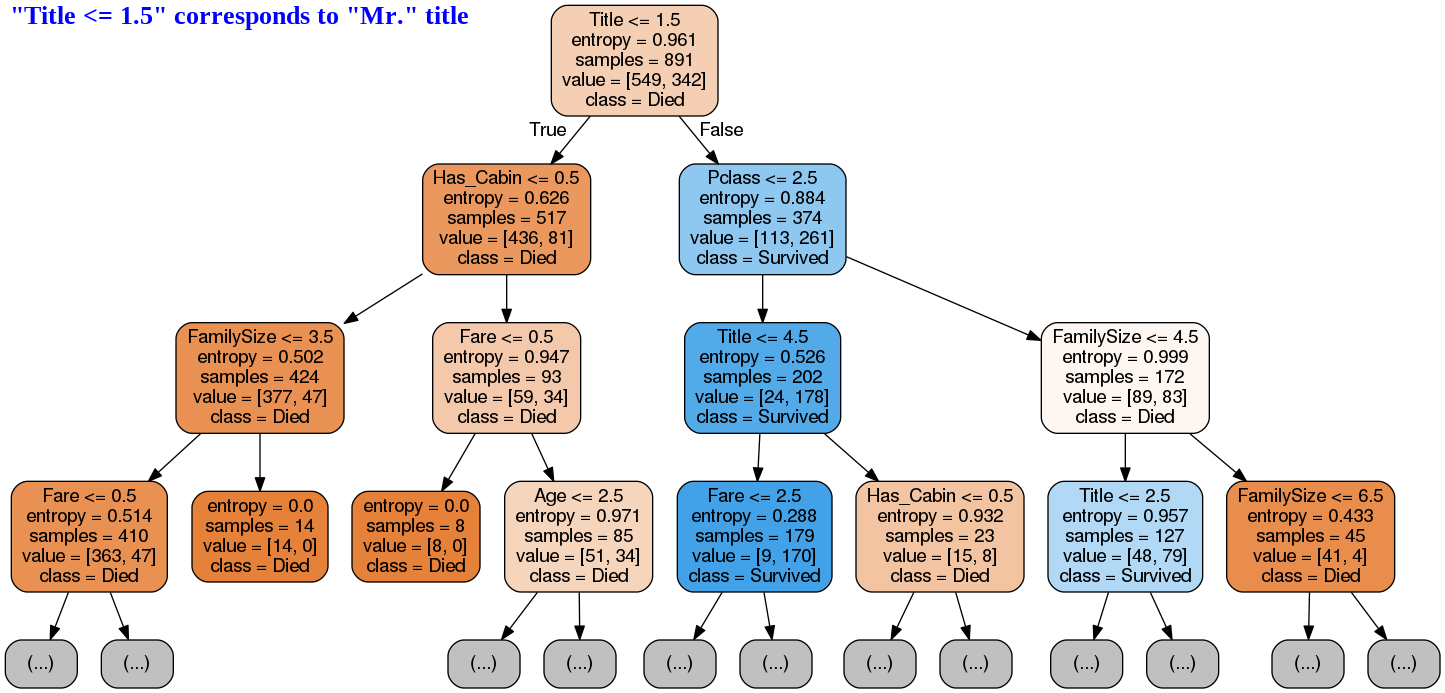

In [228]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 4
decision_tree = tree.DecisionTreeClassifier(max_depth = 5, criterion="entropy")
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")


In [229]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 4)
acc_decision_tree

84.7363

In [ ]:
sc.stop()